**BANGKIT MACHINE LEARNING AUTISM DETECTION**


In [1]:
!nvidia-smi

Mon Jun 12 15:28:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import os
import random
import time
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K


In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **PRE-PROCESSING DATA**

In [4]:
TRAINING_DIR = "/content/drive/MyDrive/BANGKITcapstone/autism/train"
VALIDATION_DIR = "/content/drive/MyDrive/BANGKITcapstone/autism/valid"
TESTING_DIR = "/content/drive/MyDrive/BANGKITcapstone/autism/test"

In [13]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):

    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                        shuffle=True,
                                                        target_size=(224, 224))

    # Instantiate the ImageDataGenerator class 
    validation_datagen = ImageDataGenerator(rescale=1./255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,                          
                                                                  class_mode='categorical',
                                                                  color_mode='rgb',
                                                                  shuffle=False,
                                                                  target_size=(224, 224))
    # Instantiate the ImageDataGenerator class 
    testing_datagen = ImageDataGenerator(rescale=1./255.)

    # Pass in the appropriate arguments to the flow_from_directory method
    testing_generator = testing_datagen.flow_from_directory(directory=TESTING_DIR,
                                                            batch_size=32,
                                                            class_mode='categorical',
                                                            color_mode='rgb',
                                                            shuffle=False,
                                                            target_size=(224, 224))

    return train_generator, validation_generator, testing_generator


In [14]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR)

Found 2526 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


**TESTING TRANSFER LEARNING**

In [15]:
from tensorflow.keras.applications import ResNet50

def new_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = True

    model = tf.keras.models.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [16]:
model = new_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24,112,770
Trainable params: 24,059,650
Non-trainable params: 53,120
_____________________________________

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15)

In [18]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [19]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 0.9 ** epoch)

**TRAIN THE MODEL**

In [20]:
model = new_model()

# Train the model

history = model.fit(train_generator,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[es, mc, lr_scheduler]
                    )

Epoch 1/100
79/79 [==============================] - 551s 6s/step - loss: 0.5439 - accuracy: 0.7367 - val_loss: 0.6994 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
79/79 [==============================] - 52s 656ms/step - loss: 0.4160 - accuracy: 0.8124 - val_loss: 0.8773 - val_accuracy: 0.5000 - lr: 9.0000e-05
Epoch 3/100
79/79 [==============================] - 51s 644ms/step - loss: 0.3532 - accuracy: 0.8393 - val_loss: 1.2731 - val_accuracy: 0.5000 - lr: 8.1000e-05
Epoch 4/100
79/79 [==============================] - 51s 648ms/step - loss: 0.3056 - accuracy: 0.8753 - val_loss: 1.5761 - val_accuracy: 0.5000 - lr: 7.2900e-05
Epoch 5/100
79/79 [==============================] - 51s 646ms/step - loss: 0.2775 - accuracy: 0.8856 - val_loss: 1.5274 - val_accuracy: 0.5000 - lr: 6.5610e-05
Epoch 6/100
79/79 [==============================] - 51s 642ms/step - loss: 0.2458 - accuracy: 0.9010 - val_loss: 1.0036 - val_accuracy: 0.5000 - lr: 5.9049e-05
Epoch 7/100
79/79 [=================

**VISUALIZE TRAINING HISTORY**

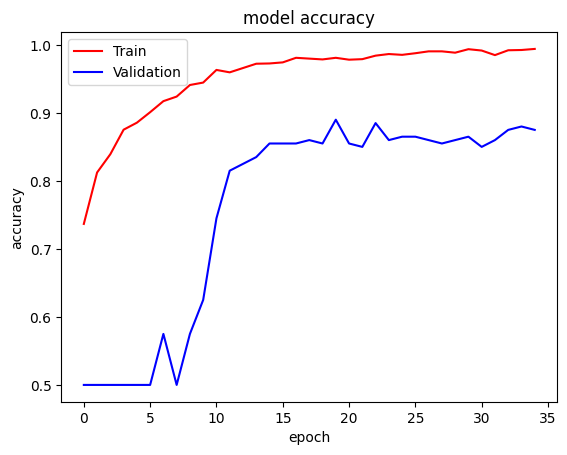

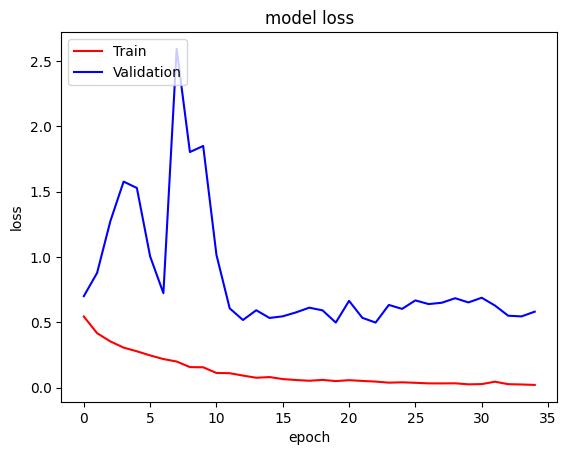

In [21]:
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# summarize history for accuracy
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
import pickle
with open('train_history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

In [23]:
  # Evaluate the best model on the training and validation data
  from tensorflow.keras.models import load_model

  # Load the best model
  best_model = load_model('/content/best_model.h5')

  # Evaluate the best model on the training and validation data
  train_results = best_model.evaluate(train_generator)
  val_results = best_model.evaluate(validation_generator)

  # Print the evaluation results
  print("Training Loss:", train_results[0])
  print("Training Accuracy:", train_results[1])
  print("Validation Loss:", val_results[0])
  print("Validation Accuracy:", val_results[1])

7/7 [==============================] - 1s 156ms/step - loss: 0.4974 - accuracy: 0.8900
Training Loss: 0.023435359820723534
Training Accuracy: 0.9920823574066162
Validation Loss: 0.4973633587360382
Validation Accuracy: 0.8899999856948853


**VISUALIZING PREDICTIONS**

7/7 [==============================] - 1s 151ms/step


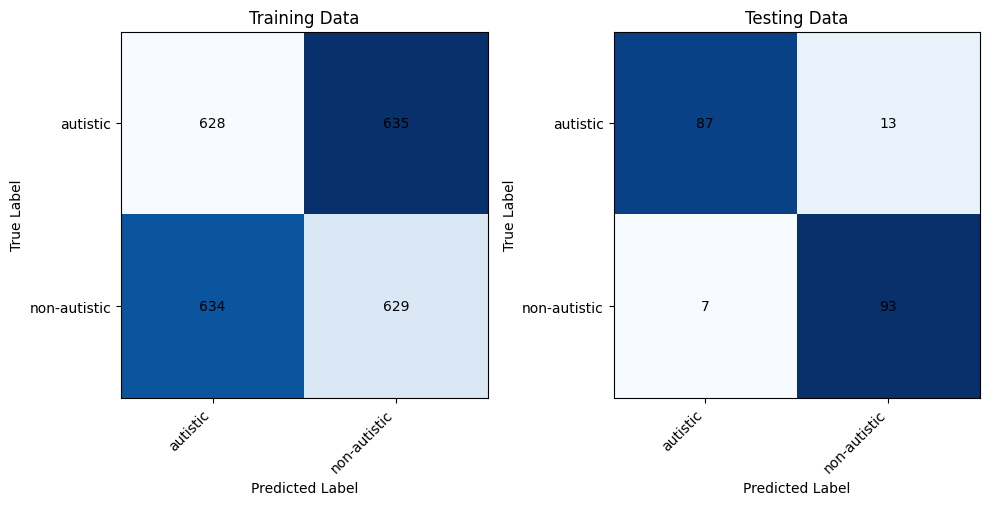

Training Data Classification Report:
              precision    recall  f1-score   support

    autistic       0.50      0.50      0.50      1263
non-autistic       0.50      0.50      0.50      1263

    accuracy                           0.50      2526
   macro avg       0.50      0.50      0.50      2526
weighted avg       0.50      0.50      0.50      2526

Testing Data Classification Report:
              precision    recall  f1-score   support

    autistic       0.93      0.87      0.90       100
non-autistic       0.88      0.93      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [27]:
# Define the classes (labels)
classes = ['autistic', 'non-autistic']

# Make predictions on training and validation data
train_predictions = model.predict(train_generator)
test_predictions = model.predict(testing_generator)

# Convert the predictions to class labels
train_pred_labels = np.round(train_predictions).argmax(axis=1)
test_pred_labels = np.round(test_predictions).argmax(axis=1)

# Get the true labels for training and validation data
train_true_labels = train_generator.classes[:len(train_pred_labels)]
test_true_labels = testing_generator.classes[:len(test_pred_labels)]

# Create a confusion matrix for training predictions
train_cm = confusion_matrix(train_true_labels, train_pred_labels)

# Create a confusion matrix for validation predictions
test_cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot the confusion matrices with values
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_cm, cmap='Blues')
axes[0].set_title('Training Data')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticks(np.arange(len(classes)))
axes[0].set_yticks(np.arange(len(classes)))
axes[0].set_xticklabels(classes)
axes[0].set_yticklabels(classes)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")
plt.setp(axes[0].get_yticklabels(), rotation=0, ha="right")

axes[1].imshow(test_cm, cmap='Blues')
axes[1].set_title('Testing Data')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticks(np.arange(len(classes)))
axes[1].set_yticks(np.arange(len(classes)))
axes[1].set_xticklabels(classes)
axes[1].set_yticklabels(classes)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")
plt.setp(axes[1].get_yticklabels(), rotation=0, ha="right")

# Annotate values in the confusion matrices
for i in range(len(classes)):
    for j in range(len(classes)):
        axes[0].text(j, i, train_cm[i, j], ha="center", va="center", color="black")
        axes[1].text(j, i, test_cm[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()

# Print the classification report
print("Training Data Classification Report:")
print(classification_report(train_true_labels, train_pred_labels, target_names=classes))
print("Testing Data Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=classes))

**SAVING THE MODEL**

In [28]:
model.save('/content/drive/MyDrive/BANGKITcapstone/best_modelResNetv4.h5')

In [29]:
!pip install tensorflowjs 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [30]:
!mkdir modelResnetv4 

In [31]:
!tensorflowjs_converter --input_format keras best_model.h5 modelResnetv4/

2023-06-12 16:28:26.888017: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [32]:
!zip -r modelResnetv4.zip modelResnetv4

  adding: modelResnetv4/ (stored 0%)
  adding: modelResnetv4/group1-shard14of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard12of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard10of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard13of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard18of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard16of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard7of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard22of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard5of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard11of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard4of23.bin (deflated 7%)
  adding: modelResnetv4/model.json (deflated 96%)
  adding: modelResnetv4/group1-shard2of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard20of23.bin (deflated 7%)
  adding: modelResnetv4/group1-shard15of23.bin (deflated 8%)
  adding: modelResnetv4/group1-shard23of23.bin (deflated 7%)
  

In [33]:
from google.colab import files
files.download('modelResnetv4.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
model = tf.keras.models.load_model('/content/best_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [35]:
with open('modelResnetv4.tflite', 'wb') as f:
    f.write(tflite_model)


In [36]:
from google.colab import files
files.download('train_history.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
from google.colab import files
files.download('modelResnetv4.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>